In [1]:
if 'google.colab' in str(get_ipython()):
  print('Running on CoLab')
  %matplotlib inline
else:
    print('Not running on CoLab')
    %matplotlib notebook
    import os
    os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
    os.environ["CUDA_VISIBLE_DEVICES"] = "1"

Not running on CoLab


In [2]:
import numpy as np
import time

import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation

from keras.models import Sequential
from keras.layers import Dense, GRU, Conv2D, Flatten, MaxPooling2D, Dropout, Reshape, TimeDistributed
from IPython.display import HTML
from funtion_file import matrix_maker, plot_training_history
from tensorflow.keras.metrics import Precision, Recall
import tensorflow as tf
import keras as ks

In [3]:


class MatrixLister:
    def __init__(self, row_len, col_len, kernel_size, min_max_line_size, rotate, num_of_mat, num_per_mat, num_neuron):
        self.row_len = row_len
        self.col_len = col_len
        self.kernel_size = kernel_size
        self.min_max_line_size = min_max_line_size
        self.rotate = rotate
        self.num_of_mat = num_of_mat
        self.num_per_mat = num_per_mat
        self.num_neuron = num_neuron

        self.con_matrix, self.line_pos_mat, self.con_alfa = self.create_matrix_in_list()
        
        self.model = None
        self.build_model((self.row_len, self.col_len), self.num_neuron)
        

    def create_matrix_in_list(self):
        list_matrix = []
        list_pos_mat = []
        list_alfa = []

        for k in range(0, self.num_of_mat):
            line_size = rotater((
                np.random.randint(self.min_max_line_size[0][0], self.min_max_line_size[1][0] + 1),
                np.random.randint(self.min_max_line_size[0][1], self.min_max_line_size[1][1] + 1)
            ))

            mat, pos, alf = matrix_maker(self.row_len, self.col_len, self.kernel_size, line_size, self.num_per_mat)

            list_matrix.append(mat)
            list_pos_mat.append(pos)
            list_alfa.append(alf)

        # Concatenate the lists along the first axis (axis=0)
        list_matrix = np.concatenate(list_matrix, axis=0)
        list_pos_mat = np.concatenate(list_pos_mat, axis=0)
        list_alfa = np.concatenate(list_alfa, axis=0)

        return list_matrix, list_pos_mat, list_alfa
    
    def make_new_matrix_in_list(self, **kwargs):
        update = False
        for key, value in kwargs.items():
            if key in ['row_len', 'col_len']:
                update = True
            if hasattr(self, key):
                setattr(self, key, value)
            else:
                print(f"Attribute {key} does not exist in the class.")
        
        self.con_matrix, self.line_pos_mat, self.con_alfa = self.create_matrix_in_list()
        
        if update:
            self.build_model((self.row_len, self.col_len), self.num_neuron)
            
    def build_model(self, input_size, num_neuron):
        model = Sequential()
        
        # Apply Conv2D and Flatten to each time step
        model.add(Conv2D(32, kernel_size=(1, 3), padding='same', activation='relu'))
        model.add(Conv2D(32, kernel_size=(3, 1), padding='same', activation='relu'))
        model.add(Conv2D(64, kernel_size=(2, 2), padding='same', activation='relu'))
        model.add(MaxPooling2D(pool_size=2))
        model.add(Conv2D(128, kernel_size=(2, 2), padding='same', activation='tanh'))
        #model.add(MaxPooling2D(pool_size=2))
        
        # Apply SimpleRNN to the output of Conv2D and Flatten
        model.add(TimeDistributed(Flatten()))
        model.add(Dense(self.row_len*self.col_len, activation='tanh'))
        model.add(GRU(num_neuron, activation='relu', return_sequences=True))
        model.add(Dropout(0.1))
        model.add(GRU(num_neuron, activation='relu'))
        model.add(Dense(num_neuron, activation='tanh'))
        
        # Fully connected layer
        model.add(Dense(input_size[0] * input_size[1], activation='sigmoid'))
        
        # Reshape to the desired output shape
        model.add(Reshape((input_size[0], input_size[1], 1)))
        
        model.compile(optimizer='adam',
        loss=custom_loss,
        metrics=['accuracy', Precision(name='precision'), Recall(name='recall')])

        self.model = model

    def train_neural_network(self, num_epochs=10, batch_size=64):
        checkpoint_filepath = 'weights.h5'
        model_checkpoint_callback = ks.callbacks.ModelCheckpoint(
        filepath=checkpoint_filepath,
        save_weights_only=True,
        monitor='val_accuracy',
        mode='max',
        save_best_only=True)
        
        in_data = np.expand_dims(self.con_matrix, -1)
        out_data = np.expand_dims(self.line_pos_mat, -1)

        return self.model.fit(in_data, out_data, epochs=num_epochs, batch_size=batch_size, callbacks=[model_checkpoint_callback], validation_split = 0.3)
        
    def predict_neural_network(self, in_data):
        input_data = np.expand_dims(np.array([matrix for matrix in in_data]),-1)
        return self.model.predict(input_data)
    
    def plot_matrices(self, num_to_pred, new_mat=False, interval=500):
        if new_mat:
            self.num_of_mat = num_to_pred
            self.con_matrix, self.line_pos_mat, self.con_alfa = self.create_matrix_in_list()
            
        input_matrix = np.array(self.con_matrix[:num_to_pred*self.num_per_mat])
        true_matrix = self.line_pos_mat[:num_to_pred*self.num_per_mat]
        
        
        pred = self.predict_neural_network(input_matrix)
    
        predicted_line_pos_mat = np.array(pred).reshape(input_matrix.shape)
        
        fig, axes = plt.subplots(1, 3, figsize=(12, 4))  # 1 row, 3 columns
    
        def update(frame):
            # Plot Input Matrix
            im = [axes[0].imshow(input_matrix[frame], interpolation='nearest', aspect='auto', vmin=0, vmax=1)]
            axes[0].set_title('Input Matrix')
    
            # Plot True Line Position Matrix
            im.append(axes[1].imshow(true_matrix[frame], interpolation='nearest', aspect='auto', vmin=0, vmax=1))
            axes[1].set_title('True Line Position Matrix')
    
            # Plot Predicted Line Position Matrix
            im.append(axes[2].imshow(predicted_line_pos_mat[frame], interpolation='nearest', aspect='auto', vmin=0, vmax=1))
            axes[2].set_title('Predicted Line Position Matrix')
            
            return im
    
        animation = FuncAnimation(fig, update, frames=len(input_matrix), interval=interval, repeat=False, blit=True)
    
        plt.tight_layout()
        return animation


def rotater(line):
    if np.random.random() < 0.5:
        return line[::-1]
    return line


def plot(matrix, interval=200):
    fig, ax = plt.subplots()

    def update(frame):
        ax.clear()
        im = ax.imshow(matrix[frame], interpolation='nearest', aspect='auto', vmin=0, vmax=1)

        return [im]

    animation = FuncAnimation(fig, update, frames=len(matrix), interval=interval, repeat=False, blit=True)
    plt.tight_layout()
    plt.show(block=False)
    plt.show()
    return animation

    
def custom_loss(y_true, y_pred):
    # Define a mask to identify positions where y_true is 1
    mask = tf.cast(y_true, dtype=tf.bool)

    # Calculate mean squared error
    mse_loss = tf.reduce_mean(tf.square(y_true - y_pred))

    # Penalize predictions less than 0.5 when y_true is 1
    penalty = tf.where(mask, tf.math.square(tf.maximum(0.5 - y_pred, 0)), 0)

    # Combine the mean squared error with the custom penalty
    combined_loss = mse_loss + 100*tf.reduce_mean(penalty)

    return combined_loss

    

In [4]:
row_len = 10
col_len = 12
kernel_size = (2, 2)
min_max_line_size = [(1,5),(1,8)]
rotate = True
num_of_mat = 250*2
numb_of_picture = 8
num_of_neurons = 256

matrix_lister = MatrixLister(row_len, col_len, kernel_size, min_max_line_size, rotate, num_of_mat, numb_of_picture, num_of_neurons)

In [5]:
batch_size = 2**9
start_epochs = 25
end_epochs = 25
hyper_epochs = 10


epochs_list = [round((-start_epochs+end_epochs)/(1+np.exp(-3*(x-hyper_epochs/4)))+start_epochs) for x in range(hyper_epochs)]
hist = []
start = time.time()
for epochs in epochs_list:
    hist.append(matrix_lister.train_neural_network(batch_size=batch_size, num_epochs=epochs))
    matrix_lister.make_new_matrix_in_list(kernel_size=(2,2), num_of_mat=250)
print(time.time() - start)

Epoch 1/25


6/6 [==============================] - 3s 185ms/step - loss: 0.2398 - accuracy: 0.7905 - precision: 0.0483 - recall: 0.1844 - val_loss: 0.2274 - val_accuracy: 0.9293 - val_precision: 0.0525 - val_recall: 0.0271
Epoch 2/25
6/6 [==============================] - 1s 88ms/step - loss: 0.2151 - accuracy: 0.9461 - precision: 0.0484 - recall: 0.0077 - val_loss: 0.2155 - val_accuracy: 0.9369 - val_precision: 0.0583 - val_recall: 0.0201
Epoch 3/25
6/6 [==============================] - 1s 85ms/step - loss: 0.2103 - accuracy: 0.9481 - precision: 0.0877 - recall: 0.0108 - val_loss: 0.2140 - val_accuracy: 0.9516 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 4/25
6/6 [==============================] - 0s 80ms/step - loss: 0.2083 - accuracy: 0.9529 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 0.2146 - val_accuracy: 0.9516 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 5/25
6/6 [==============================] - 0s 80ms/step - loss: 0.2078 - accuracy:

In [6]:
ani = matrix_lister.plot_matrices(20)
plt.show()

5/5 [==============================] - 0s 6ms/step


<IPython.core.display.Javascript object>

In [7]:
if 'google.colab' in str(get_ipython()):
    HTML(ani.to_html5_video())

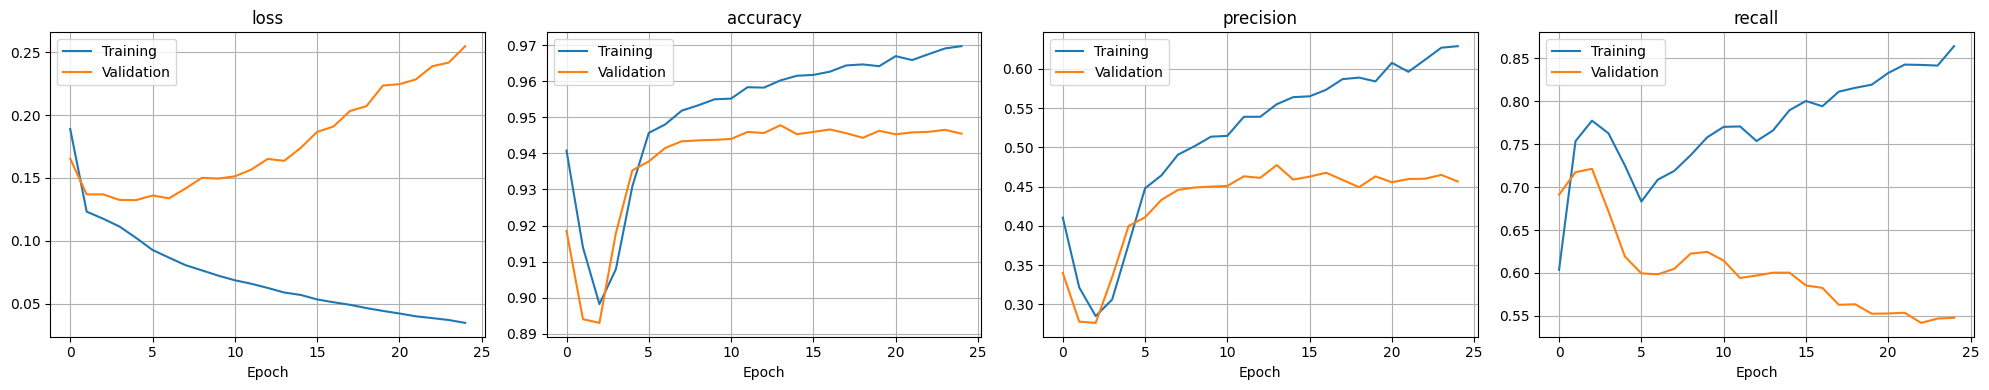

In [13]:
%matplotlib inline
plot_training_history(hist[4]) 